<a href="https://colab.research.google.com/github/Zahra-Ferdous/Thesis_Human_Action_Recognition_from_Depth_Video/blob/main/depth_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import math
%matplotlib inline
import os
import time

from numba.core.cgutils import if_likely
#from os.path import exists
import os.path 

import cv2
import sklearn
import scipy.io as sio
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from astropy.timeseries import LombScargle
from scipy.io import loadmat


import imageio
from skimage import feature

In [ ]:
def resize_feature(y,fix_size):
    
    # Min Max Norm
    
    x = y.resize((fix_size),Image.ANTIALIAS)
    x = x.reshape(-1)
    
    mask = x
    if np.min(x) < 0:
        x = x + abs(np.min(x)) * 2

    x[mask==0] = 0
    x = np.divide( (x-np.min(x)) , (np.max(x) - np.min(x)) )
    #x = (x-np.min(x)) ./ (max(x)-min(x));
    
    return x

In [ ]:
def abs1p(array):
    for i in range(len(array)):
        if array[i].any() < 0:
             array[i] = array[i] * (-1)
    return array

In [ ]:
def bounding_box(img):
    
    # Cut out the parts with only background
    
    row, col = img.shape
    top = 0
    bottom = row
    left = 0
    right = col
    
    for i in range (row):
        if (np.sum(img[i,:]) > 0):
            top = i
            break
            
    for i in range (row-1, -1, -1):
        if (np.sum(img[i,:]) > 0):
            bottom = i
            break
            
    for i in range (col):
        if (np.sum(img[:,i]) > 0):
            left = i
            break
                  
    for i in range (col-1, -1, -1):
        if (np.sum(img[:,i]) > 0):
            right = i
            break
    
    y = img[top:bottom, left:right]
                  
    return y

In [ ]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

def denoise(image,lower,upper):
    drawing = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j] < lower):
                drawing[i,j] = 0
            elif(image[i,j] > upper):
                drawing[i,j] = 255
            else:
                drawing[i,j]=image[i,j]
    return drawing

#image preprocessing
def rct(img):
    drawing = denoise(img,50,98)#set threshold for the depth image
#     plt.imshow(cv2.cvtColor(drawing, 0))
#     plt.show()

    img1  = auto_canny(cv2.GaussianBlur(drawing, (5, 5), 0))
#     plt.imshow(cv2.cvtColor(img1, 0))
#     plt.title('after canny')
#     plt.show()

    img1  = cv2.dilate(img1, None, iterations=2)
#     plt.imshow(cv2.cvtColor(img1, 0))
#     plt.title('after dilation')
#     plt.show()

    img1  = cv2.erode(img1, None, iterations=2)
#     plt.imshow(cv2.cvtColor(img1, 0))
#     plt.title('after erosion')
#     plt.show()

    cropped = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    #cropped[30:108,60:120]=img1[30:108,60:120]# get the interested region

    cropped[50:350, 100:400]=img1[50:350,100:400]
#     plt.imshow(cv2.cvtColor(cropped, 0))
#     plt.title('after crop')
#     plt.show()

    #drawing box
    contours, _ = cv2.findContours(cropped, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # img1 er jaygay cropped chilo
    #print(contours)
    
    #cnts = imutils.grab_contours(contours)
    #print("[INFO] {} unique contours found".format(len(cnts)))
    
#     print(len(contours))
#     for i in range(len(contours)):
#         print(cv2.contourArea(contours[i]))

    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:1] # descending order and take the 1st element
    
    #print(len(contours))
    #print(cv2.contourArea(contours[0]))

#     screenCnt = None
#     contours_poly = [None]*len(contours)
# #    print(contours_poly)
#     boundRect = [None]*len(contours)
# #    print(boundRect)
#     for i, c in enumerate(contours):
#         contours_poly[i] = cv2.approxPolyDP(c, 3, True)
#         boundRect[i] = cv2.boundingRect(contours_poly[i])
# #        print(boundRect[i])

    #boundRect = [None]*len(contours) 
    contours_poly = cv2.approxPolyDP(contours[0], 3, True)
    boundRect  = cv2.boundingRect(contours_poly)  
    
    res = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    #print result
    left = boundRect[0]-10
    right =(boundRect[0]+boundRect[2])+10
    bottom = (boundRect[1]+boundRect[3])+10
    top = boundRect[1]-10
    
    res [ top:bottom, left:right ] = img [ top:bottom, left:right ] 
    
    #print(f"left = {left}, right = {right}, top = {top}, bottom = {bottom}")
            
    
    return res

In [ ]:
def depth_projection(X):
    
    X1 = X
    (dep, row, col) = X1.shape

    #print(X1.shape)

    X_2d = X1.reshape(row*col , dep)
    X_2d.shape

    maxDep = np.amax(X_2d)
    maxDep
    #print(maxDep)

    F = np.zeros((row, col))         # Front
    S = np.zeros((row, maxDep))      # Side
    T = np.zeros((maxDep, col))      # Top

    for k in range(0,dep):
        front = X[k,:,:]
        #print("front {}".format(front))

        front = front.reshape(-1)   # flatten the array to 1d
        #print("front {}".format(front))

        front = front.reshape(row, col)
        side = np.zeros((row, maxDep))  
        top = np.zeros((maxDep, col))

        for i in range(row):
            for j in range(col):
                if front[i][j] != 0:
                    #print("i = {}, j = {}, front[i][j]-1 = {}".format(i,j,front[i,j]-1))
                    side[i,front[i,j]-1] = j   # side view projection (y-z projection)
                    top[front[i,j]-1,j] = i    # top view projection  (x-z projection)
                    
        
        #print("side {}".format(side))
        #print("top {}".format(top))
        
        if k > 0:
            
            # F = F + abs1p(front - front_pre)
            # S = S + abs1p(side - side_pre)
            # T = T + abs1p(top - top_pre)

            F = np.add( F, np.absolute( np.subtract( front, front_pre ) ) )
            S = np.add( S, np.absolute( np.subtract( side, side_pre ) ) )
            T = np.add( T, np.absolute( np.subtract( top, top_pre ) ) )

            # print(k)

            # unique1, counts1 = np.unique(F, return_counts=True)
            # print( dict(zip(unique1, counts1)) )  

            # unique1, counts1 = np.unique(S, return_counts=True)
            # print( dict(zip(unique1, counts1)) )  

            # unique1, counts1 = np.unique(T, return_counts=True)
            # print( dict(zip(unique1, counts1)) )
            '''
            F = F + float ( abs[i] for i in ((front - front_pre)))
            S = S + float ( abs[i] for i in ((side - side_pre)))
            T = T + float ( abs[i] for i in ((top - top_pre)))
            '''
        front_pre = front
        side_pre  = side
        top_pre   = top    

        
        # unique1, counts1 = np.unique(front, return_counts=True)
        # print( dict(zip(unique1, counts1)) )  

        # unique1, counts1 = np.unique(side, return_counts=True)
        # print( dict(zip(unique1, counts1)) )  

        # unique1, counts1 = np.unique(top, return_counts=True)
        # print( dict(zip(unique1, counts1)) )  
        
    # print("side {}".format(S.max()))
    # print("front {}".format(F.max()))
    # print("top {}".format(T.max()))
    
    # F = bounding_box(F)
    # S = bounding_box(S)
    # T = bounding_box(T)
    # print("FINAL")
    # unique1, counts1 = np.unique(F, return_counts=True)
    # print( dict(zip(unique1, counts1)) )  

    # unique1, counts1 = np.unique(S, return_counts=True)
    # print( dict(zip(unique1, counts1)) )  

    # unique1, counts1 = np.unique(T, return_counts=True)
    # print( dict(zip(unique1, counts1)) )
   
    return (F, S, T)

In [ ]:
def lbp_features(img, radius=1, sampling_pixels=8):
    '''
    # LBP operates in single channel images so if RGB images are provided
    # we have to convert it to grayscale
    if (len(img.shape) > 2):
        img = img.astype(float)
        # RGB to grayscale convertion using Luminance
        img = img[:,:,0]*0.3 + img[:,:,1]*0.59 + img[:,:,2]*0.11

    # converting to uint8 type for 256 graylevels
    img = img.astype(np.uint8)
    norm = np.zeros((800,800))
    # normalize values can also help improving description
    try:
        i_min = np.min(img)
        i_max = np.max(img)
        if (i_max - i_min != 0):
            img = (img - i_min)/(i_max-i_min)
    except ValueError:  #raised if zero-size array to reduction operation minimum which has no identity
        img = cv2.normalize(img,  norm, 0, 255, cv2.NORM_MINMAX)
        #pass
        
    #$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
    # print("image shape")
    # print(img.shape)
    '''
    # compute LBP
    lbp = feature.local_binary_pattern(img, sampling_pixels, radius, method="uniform")
    print(lbp.shape)
    
    # LBP returns a matrix with the codes, so we compute the histogram
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, sampling_pixels + 3), range=(0, sampling_pixels + 2))

    # normalization
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    # return the histogram of Local Binary Patterns
    #d = {'lbp': lbp, 'hist': hist}
    return lbp,hist

def Euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return dist

In [ ]:
#l_ser = []
path = '/content/drive/MyDrive/Colab Notebooks/DPT_image'

cnt=0

start = time.time()

for file in os.listdir(path):
    if file.endswith('.mat'):
      cnt+=1
      
      file_exists = os.path.exists('/content/drive/MyDrive/Colab Notebooks/DPT3/'+file)
      print(cnt);
      # print(file_exists)
      if file_exists:
        print(file)
        continue
      if cnt == 1000:
        continue

      datla = sio.loadmat(path+'/'+file)
      print(datla.keys)
      dat = sio.loadmat(path+'/'+file)['pre_depth']
      #
      plt.imshow(dat[10], interpolation='nearest')
      plt.title("side"+file)
      plt.show()
      '''
      p1_dat = np.zeros((dat.shape[0], dat.shape[1], dat.shape[2]), dtype=np.uint8)
      
      num_rows = dat.shape[0]
      
      # Image preprocessing and foreground mining
      for i in range(5,num_rows-5):
          matrix = rct(dat[i,:,:])
          matrix[np.where((matrix < 70))] = 0
          matrix[np.where((matrix > 98))] = 0
          p1_dat[i] = matrix
      '''    
      # DMM projections
      (F, S, T) = depth_projection(dat)
      plt.imshow(F, interpolation='nearest')
      plt.title("front"+file)
      plt.show()

      plt.imshow(T, interpolation='nearest')
      plt.title("top"+file)
      plt.show()

      plt.imshow(S, interpolation='nearest')
      plt.title("side"+file)
      plt.show()
      
      # LBP 
      ls,hist_s = lbp_features(S)
      lf,hist_f = lbp_features(F)
      lt,hist_t = lbp_features(T)
      
      vals = range(len(lf))
      plt.figure(figsize=(10,5))
    
      # plt.subplot(231); plt.bar(vals,lf); 
      # plt.title('lbp of Front'); plt.axis('off')

      # plt.subplot(232); plt.bar(vals,ls); 
      # plt.title('lbp of Side'); plt.axis('off')

      # plt.subplot(233); plt.bar(vals,lt); 
      # plt.title('lbp of Top'); plt.axis('off')
    
      # plt.show()

      x = file.split("_")
      act = x[1]
      #print(act)

      #d = {'front':F, 'side':S, 'top':T, 'lbp_f':lf, 'lbp_s':ls, 'lbp_t':lt, 'hist_f':hist_f, 'hist_s':hist_s, 'hist_t':hist_t, 'action':act}

      #ser = pd.Series(data = d, index = ['front','side', 'top','lbp_f', 'lbp_s', 'lbp_t', 'hist_f', 'hist_s', 'hist_t', 'action' ])

      #cols = ['front','side', 'top','lbp_f', 'lbp_s', 'lbp_t', 'hist_f', 'hist_s', 'hist_t', 'action' ]

      #l_ser.append(ser)

      sio.savemat('/content/drive/MyDrive/Colab Notebooks/DPT2/all_data3.mat',{'front': F,'side': S,'top': T,'lbp_f':lf,'lbp_s':ls,'lbp_t':lt,'hist_f':hist_f, 'hist_s':hist_s, 'hist_t':hist_t,'action':act})
      sio.savemat('/content/drive/MyDrive/Colab Notebooks/DPT3/' + file, {'pre_depth': dat,'front': F,'side': S,'top': T,'lbp_f':lf,'lbp_s':ls,'lbp_t':lt,'hist_f':hist_f, 'hist_s':hist_s, 'hist_t':hist_t,'action':act})
      #cnt = cnt + 1


end = time.time()
print(end-start)


1
qyh_a12_t9.mat
2
qyh_a12_t8.mat
3
qyh_a12_t2.mat
4
qyh_a12_t6.mat
5
qyh_a12_t7.mat
6
cyy_a10_t2.mat
7
qyh_a13_t1.mat
8
cyy_a10_t7.mat
9
cx_a19_t11.mat
10
cyy_a10_t3.mat
11
cyy_a10_t4.mat
12
cyy_a10_t6.mat
13
cyy_a10_t5.mat
14
cyy_a10_t8.mat
15
cyy_a11_t1.mat
16
cyy_a10_t9.mat
17
cyy_a10_t10.mat
18
cx_a9_t8.mat
19
cyy_a10_t1.mat
20
cx_a9_t9.mat
21
cx_a9_t6.mat
22
cx_a9_t5.mat
23
cx_a9_t7.mat
24
cx_a9_t4.mat
25
cx_a9_t3.mat
26
cx_a9_t13.mat
27
cx_a9_t12.mat
28
cx_a9_t11.mat
29
cx_a9_t2.mat
30
cx_a9_t10.mat
31
cx_a8_t7.mat
32
cx_a9_t1.mat
33
cx_a8_t8.mat
34
cx_a8_t5.mat
35
cx_a8_t4.mat
36
cx_a8_t6.mat
37
cx_a8_t9.mat
38
cx_a8_t3.mat
39
cx_a8_t12.mat
40
cx_a8_t13.mat
41
cx_a8_t2.mat
42
cx_a8_t1.mat
43
cx_a8_t10.mat
44
cx_a7_t6.mat
45
cx_a8_t11.mat
46
cx_a7_t8.mat
47
cx_a7_t9.mat
48
cx_a7_t5.mat
49
cx_a7_t7.mat
50
cx_a7_t4.mat
51
cx_a7_t3.mat
52
cx_a7_t11.mat
53
cx_a7_t10.mat
54
cx_a7_t2.mat
55
cx_a7_t12.mat
56
cx_a7_t13.mat
57
cx_a7_t1.mat
58
cx_a6_t5.mat
59
cx_a6_t9.mat
60
cx_a6_t7.mat


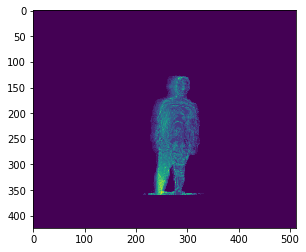

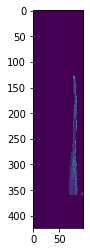

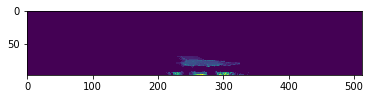

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DPT3/qyh_a12_t9.mat'
dat = sio.loadmat(path)

'''      
row = 424
col = 512
dep = 255

# for front padding

f = dat.get('front')
tb1 = row - f.shape[0]
lr1 = col - f.shape[1]

if tb1 % 2==1 :
  top1 = tb1//2
  bottom1 = tb1//2 + 1
else:
  top1 = tb1//2
  bottom1 = tb1//2

if lr1 % 2 == 1:
  left1 =lr1//2
  right1 = lr1//2 + 1
else:
  left1 = lr1//2
  right1 = lr1//2

front = cv2.copyMakeBorder(f, top1, bottom1, left1, right1, cv2.BORDER_REPLICATE)

lbp_f,hist_f = lbp_features(front)

# for side padding

s = dat.get('side')
tb2 = row - s.shape[0]
lr2 = dep - s.shape[1]

plt.imshow(s, interpolation='nearest')
plt.show()

if tb2 % 2 == 1:
  top2 = tb2//2
  bottom2 = tb2//2 + 1
else:
  top2 = tb2//2
  bottom2 = tb2//2

if lr2 % 2 == 1:
  left2 = lr2//2
  right2 = lr2//2 + 1
else:
  left2 = lr2//2
  right2 = lr2//2

side = cv2.copyMakeBorder(s, top2, bottom2, left2, right2, cv2.BORDER_REPLICATE)
lbp_s,hist_s = lbp_features(side)

# for top padding

t = dat.get('top')
tb3 = dep - t.shape[0]
lr3 = col - t.shape[1]

plt.imshow(t, interpolation='nearest')
plt.show()

if tb3 % 2 == 1:
  top3 = tb3//2
  bottom3 = tb3//2 + 1
else:
  top3 = tb3//2
  bottom3 = tb3//2

if lr3 % 2 == 1:
  left3 = lr3//2
  right3 = lr3//2 + 1
else:
  left3 = lr3//2
  right3 = lr3//2

top = cv2.copyMakeBorder(t, top3, bottom3, left3, right3, cv2.BORDER_REPLICATE)

lbp_t,hist_t = lbp_features(top)
'''
act = dat.get('action')
#act = dat.get('action')
front = dat.get('front')
side = dat.get('side')
top = dat.get('top')
lbp_f = dat.get('lbp_f')
lbp_s = dat.get('lbp_s')
lbp_t = dat.get('lbp_t')
hist_f = dat.get('hist_f')
hist_s = dat.get('hist_s')
hist_t = dat.get('hist_t')

plt.imshow(front, interpolation='nearest')
plt.show()

plt.imshow(side, interpolation='nearest')
plt.show()

plt.imshow(top, interpolation='nearest')
plt.show()
d = {'front':front, 'side':side, 'top':top, 'lbp_f':lbp_f, 'lbp_s':lbp_s, 'lbp_t':lbp_t, 'hist_f':hist_f, 'hist_s':hist_s, 'hist_t':hist_t, 'action':act}

ser = pd.Series(data = d, index = ['front','side', 'top','lbp_f', 'lbp_s', 'lbp_t', 'hist_f', 'hist_s', 'hist_t', 'action' ])
l_ser = [ser]
#df = pd.DataFrame(ser)

In [ ]:
#print(df.head(10))

In [ ]:

path = '/content/drive/MyDrive/Colab Notebooks/DPT3/'
cnt = 0
for file in os.listdir(path):
    if file.endswith('.mat'):
      cnt+=1
      #file_exists = os.path.exists('/content/drive/MyDrive/Colab Notebooks/DPT_image/'+file)
      print(file);
      print(cnt)

      # if cnt < 1000:
      #   continue
      if cnt == 1 :
        continue
      if cnt == 13 :
        continue

      dat = sio.loadmat(path+'/'+file)
      #print(dat.keys())
      '''
      row = 424
      col = 512
      dep = 255

      # for front padding

      f = dat.get('front')
      tb1 = row - f.shape[0]
      lr1 = col - f.shape[1]

      if tb1 % 2==1 :
        top1 = tb1//2
        bottom1 = tb1//2 + 1
      else:
        top1 = tb1//2
        bottom1 = tb1//2

      if lr1 % 2 == 1:
        left1 =lr1//2
        right1 = lr1//2 + 1
      else:
        left1 = lr1//2
        right1 = lr1//2

      front = cv2.copyMakeBorder(f, top1, bottom1, left1, right1, cv2.BORDER_CONSTANT, None, value = 0)

      lbp_f,hist_f = lbp_features(front)

      # for side padding

      s = dat.get('side')
      tb2 = row - s.shape[0]
      lr2 = dep - s.shape[1]

      if tb2 % 2 == 1:
        top2 = tb2//2
        bottom2 = tb2//2 + 1
      else:
        top2 = tb2//2
        bottom2 = tb2//2

      if lr2 % 2 == 1:
        left2 = lr2//2
        right2 = lr2//2 + 1
      else:
        left2 = lr2//2
        right2 = lr2//2

      side = cv2.copyMakeBorder(s, top2, bottom2, left2, right2, cv2.BORDER_CONSTANT, None, value = 0)

      lbp_s,hist_s = lbp_features(side)

      # for top padding

      t = dat.get('top')
      tb3 = dep - t.shape[0]
      lr3 = col - t.shape[1]

      if tb3 % 2 == 1:
        top3 = tb3//2
        bottom3 = tb3//2 + 1
      else:
        top3 = tb3//2
        bottom3 = tb3//2

      if lr3 % 2 == 1:
        left3 = lr3//2
        right3 = lr3//2 + 1
      else:
        left3 = lr3//2
        right3 = lr3//2

      top = cv2.copyMakeBorder(t, top3, bottom3, left3, right3, cv2.BORDER_CONSTANT, None, value = 0)

      lbp_t,hist_t = lbp_features(top)
      '''
      act = dat.get('action')
      front = dat.get('front')
      side = dat.get('side')
      top = dat.get('top')
      lbp_f = dat.get('lbp_f')
      lbp_s = dat.get('lbp_s')
      lbp_t = dat.get('lbp_t')
      hist_f = dat.get('hist_f')
      hist_s = dat.get('hist_s')
      hist_t = dat.get('hist_t')


      
      d = {'front':front, 'side':side, 'top':top, 'lbp_f':lbp_f, 'lbp_s':lbp_s, 'lbp_t':lbp_t, 'hist_f':hist_f, 'hist_s':hist_s, 'hist_t':hist_t, 'action':act}

      ser = pd.Series(data = d, index = ['front','side', 'top','lbp_f', 'lbp_s', 'lbp_t', 'hist_f', 'hist_s', 'hist_t', 'action' ])

      cols = ['front','side', 'top','lbp_f', 'lbp_s', 'lbp_t', 'hist_f', 'hist_s', 'hist_t', 'action' ]

      l_ser.append(ser)

      #print(l_ser)

      #file_exists = os.path.exists('/content/drive/MyDrive/Colab Notebooks/DPT_image/'+file)
      #print(ser)



      #df = df.append(ser, ignore_index = True)

      #print(df[cnt])

      
      
      # print(list(dat.keys()))
      # l = list(dat.keys())[3:]
      # for a in l:
      #  print(dat.get(a).shape)
      # if cnt%100 != 0: 
      #   continue
      #lbp1 = lbp_features(dat.get('front'))
      

cx_a8_t10.mat
1
cx_a7_t6.mat
2
cx_a8_t11.mat
3
cx_a7_t8.mat
4
cx_a7_t9.mat
5
cx_a7_t5.mat
6
cx_a7_t7.mat
7
cx_a7_t4.mat
8
cx_a7_t3.mat
9
cx_a7_t11.mat
10
cx_a7_t10.mat
11
cx_a7_t2.mat
12
cx_a7_t12.mat
13
cx_a7_t13.mat
14
cx_a7_t1.mat
15
cx_a6_t5.mat
16
cx_a6_t9.mat
17
cx_a6_t7.mat
18
cx_a6_t8.mat
19
cx_a6_t3.mat
20
cx_a6_t6.mat
21
cx_a6_t2.mat
22
cx_a6_t4.mat
23
cx_a6_t11.mat
24
cx_a6_t13.mat
25
cx_a6_t12.mat
26
cx_a6_t10.mat
27
cx_a6_t1.mat
28
cx_a5_t8.mat
29
cx_a5_t9.mat
30
cx_a5_t4.mat
31
cx_a5_t7.mat
32
cx_a5_t6.mat
33
cx_a5_t5.mat
34
cx_a5_t3.mat
35
cx_a5_t13.mat
36
cx_a5_t1.mat
37
cx_a5_t2.mat
38
cx_a5_t12.mat
39
cx_a5_t11.mat
40
cx_a5_t10.mat
41
cx_a4_t8.mat
42
cx_a4_t3.mat
43
cx_a4_t9.mat
44
cx_a4_t7.mat
45
cx_a4_t6.mat
46
cx_a4_t2.mat
47
cx_a4_t12.mat
48
cx_a4_t5.mat
49
cx_a4_t4.mat
50
cx_a4_t13.mat
51
cx_a4_t11.mat
52
cx_a3_t9.mat
53
cx_a4_t10.mat
54
cx_a4_t1.mat
55
cx_a3_t8.mat
56
cx_a3_t6.mat
57
cx_a3_t7.mat
58
cx_a3_t2.mat
59
cx_a3_t5.mat
60
cx_a3_t4.mat
61
cx_a3_t13.mat
6

In [ ]:
df = pd.DataFrame(l_ser, columns=cols)
print(df.shape)
df.head(10)

(1165, 10)


,front,side,top,lbp_f,lbp_s,lbp_t,hist_f,hist_s,hist_t,action
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.004049049233471914, 0.005753427181577271, ...","[[0.004837312283287511, 0.005487100500445536, ...","[[0.0029695471938183684, 0.0033083545917708, 0...",[a12]
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.005048643867901272, 0.007061652417420301, ...","[[0.006955140546617368, 0.00844724682305431, 0...","[[0.004763233418272416, 0.004544005101950255, ...",[a7]
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.005288178066013376, 0.007181419516476353, ...","[[0.0061850211781337835, 0.007917789757221847,...","[[0.00566007653049944, 0.006417410714157816, 0...",[a8]
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.0054079451650694286, 0.00731961232307949, ...","[[0.006834809395291808, 0.00784559106642651, 0...","[[0.0057796556121297105, 0.0049625318876561995...",[a7]
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.0060850899174247994, 0.007439379422135542,...","[[0.006401617250519792, 0.008110319599342743, ...","[[0.005361128826423766, 0.0058394451529448456,...",[a7]
5,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.005523105837238709, 0.00664707399761089, 0...","[[0.005992491336012888, 0.007436465151919608, ...","[[0.00400589923461404, 0.004384566326443229, 0...",[a7]
6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.005495467275918081, 0.007485443691003254, ...","[[0.0064978821715802396, 0.007917789757221847,...","[[0.005281409438670253, 0.0057597257651913316,...",[a7]
7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,...","[[0.004938089622618763, 0.00702019457543936, 0...","[[0.006257219868929119, 0.006882941855822031, ...","[[0.004783163265210794, 0.004404496173381607, ...",[a7]
8,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [ ]:
# get 85 % reproducable sample from df for training

df_train = df.sample(frac=0.85, random_state=42)
df_test = df.loc[~df.index.isin(df_train.index)]

print(df_train.shape)
print(df_test.shape)

df_train_front = df_train['front']
df_test_front = df_test['front']

df_train_side = df_train['side']
df_test_side = df_test['side']

df_train_top = df_train['top']
df_test_top = df_test['top']

train_labels = df_train['action']
test_labels = df_test['action']

df_test_front.head()

(990, 10)
(175, 10)


1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
14    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
20    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
21    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: front, dtype: object

In [ ]:
df_test_front.iloc[0].shape

(424, 512)

In [ ]:
#sio.savemat('/content/drive/MyDrive/Colab Notebooks/DPT_image/depth_proc_all.mat',{name: col.values for name, col in df.items()})
print(lbp_f.max())
print(lbp_f.min())

9.0
0.0


In [ ]:
#filepath = '/content/drive/MyDrive/Colab Notebooks/depth_data.csv'

#df.to_csv(filepath) 

# file_exists = os.path.exists('/content/drive/MyDrive/Colab Notebooks/DPT_image/myj_a3_t3.mat')

# print(file_exists)

#dat1 = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/DPT_image/depth_proc_all.mat')
sio.savemat('/content/drive/MyDrive/Colab Notebooks/depth_proc_all.mat',{name: col.values for name, col in df.items()})
#sio.savemat('/content/drive/MyDrive/Colab Notebooks/depth_proc_all.mat',{name: col.values for name, col in df.items()})
#sio.savemat('/content/drive/MyDrive/Colab Notebooks/depth_proc_all.mat',{name: col.values for name, col in df.items()})

In [ ]:
df2 = df[['front','side','top','action']]
df3 = df[['lbp_f','lbp_s','lbp_t','action']]
df4 = df[['hist_f','hist_s','hist_t','action']]

In [ ]:
sio.savemat('/content/drive/MyDrive/Colab Notebooks/dmm.mat',{name: col.values for name, col in df2.items()})
sio.savemat('/content/drive/MyDrive/Colab Notebooks/lbp.mat',{name: col.values for name, col in df3.items()})
sio.savemat('/content/drive/MyDrive/Colab Notebooks/hist.mat',{name: col.values for name, col in df4.items()})